# Constructing the datasets

We will use vanilla PyTorch. We will convert audio to spectrograms and use the Emitter as our label of choice (speaker recognition is an important task, it is assumed that in order for a language to form, one needs to be able to identify who is speaking).

In [2]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing

import torch

In [3]:
anno = pd.read_csv('data/annotations.csv')

Let's keep the sample rate of 250_000 Hz but only take the first second of the recording. This can be modified to taking random porition of a file of 1 second duration to improve the results.

Additionally, we will zero pad examples that are less than 1 second.

Let us load a single wave file to take a closer look at the processing we will apply.

In [38]:
recording, _ = librosa.load(f'data/audio/{anno.iloc[0]["File Name"]}', sr=None)

In [41]:
recording.shape

(336719,)

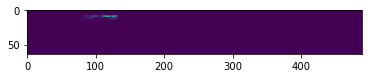

In [49]:
spec = librosa.feature.melspectrogram(
    recording[:250_000], fmin=200, fmax=250_000 // 2, n_mels=64
)
plt.imshow(spec);

In [50]:
anno.head()

,Emitter,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,File Name
0,118,0,9,2,2,3,3,0.wav
1,0,0,11,0,0,0,0,1.wav
2,118,0,12,2,2,3,3,2.wav
3,0,0,12,0,0,0,0,3.wav
4,0,0,12,0,0,0,0,4.wav


In [52]:
emitters = anno.Emitter.unique().tolist()

emitter2idx = {emitter: idx for idx, emitter in enumerate(emitters)}

In [54]:
len(emitters)

83

In [58]:
anno.Emitter.value_counts()

 0      7858
-215    6351
 215    6150
-231    4303
-211    3943
        ... 
 118      62
-223      58
-108      57
-105      39
-113       6
Name: Emitter, Length: 83, dtype: int64

The dataset is unbalanced to a great extent. This is something to keep in mind when considering the metric to use. Limiting the task to for instance the 20 best represented individuals or addressing the class imbalance via oversampling (or some other method) might also be a viable option.

In [60]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
split = list(skf.split(np.arange(anno.shape[0]), anno.Emitter))[0]

In [61]:
split

(array([    1,     2,     3, ..., 91077, 91078, 91079]),
 array([    0,     8,     9, ..., 91072, 91074, 91076]))

In [64]:
anno.iloc[split[0]].Emitter.value_counts()

 0      6287
-215    5081
 215    4920
-231    3442
-211    3155
        ... 
 118      49
-223      47
-108      46
-105      31
-113       5
Name: Emitter, Length: 83, dtype: int64

In [65]:
anno.iloc[split[1]].Emitter.value_counts()

 0      1571
-215    1270
 215    1230
-231     861
-211     788
        ... 
 103      13
-108      11
-223      11
-105       8
-113       1
Name: Emitter, Length: 83, dtype: int64

In [81]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.examples = df
        
    def __getitem__(self, index):
        example = self.examples.iloc[index]
        recording, _ = librosa.load(f'data/audio/{example["File Name"]}', sr=None)
        audio = np.zeros((250_000))
        audio[:recording.shape[0]] = recording[:250_000]
        
        x = librosa.feature.melspectrogram(
            audio, fmin=200, fmax=250_000, n_mels=64
        )
        y = emitter2idx[example.Emitter]
        return x, y

    def __len__(self):
        return self.examples.shape[0]

In [82]:
train_ds = Dataset(anno.iloc[split[0]])
valid_ds = Dataset(anno.iloc[split[1]])

In [83]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count()-1
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count()-1
)

In [ ]:
for batch in train_dl: pass
for batch in valid_dl: pass

In [85]:
batch[0].shape, batch[1].shape # we are on the final batch, there were not enough examples to fill it

(torch.Size([8, 64, 489]), torch.Size([8]))